In [1]:
import networkx as nx
import pydantic
from openai import AsyncOpenAI
import httpx
import dotenv
import os
from typing import Literal, Mapping
from generative_agents import AgentModelBase
from data_generation_utils import generate_dataset_from_graph
import matplotlib.pyplot as plt


dotenv.load_dotenv()

api_key = os.getenv("OPENAI_API_KEY") or None
client = AsyncOpenAI(
    base_url=os.getenv("OPENAI_BASE_URL"),
    api_key=api_key,
    http_client=httpx.AsyncClient(
        http2=True,
        timeout=120.0,
        limits=httpx.Limits(max_connections=1000, max_keepalive_connections=20),
    ),
)
model = os.getenv("OPENAI_COMPLETIONS_MODEL") or ""

Firstly, let us generate random social networks with some properties. We have 2 options, `nx.extended_barabasi_albert_graph` and `nx.powerlaw_cluster_graph`


In [2]:
def print_graph_properties(graph: nx.Graph):
    print(f"Number of nodes: {graph.number_of_nodes()}")
    print(f"Number of edges: {graph.number_of_edges()}")
    print(f"Density: {nx.density(graph)}")
    print(f"Average degree: {sum(dict(graph.degree()).values()) / graph.number_of_nodes() if graph.number_of_nodes() > 0 else 0}")
    print(f"Is connected: {nx.is_connected(graph)}")
    print(f"Average clustering coefficient: {nx.average_clustering(graph)}")
    print(f"Diameter: {nx.diameter(graph)}" if nx.is_connected(graph) else "Graph is not connected, diameter is undefined")
    print(f"Average shortest path length: {nx.average_shortest_path_length(graph)}" if nx.is_connected(graph) else "Graph is not connected, average shortest path length is undefined")
    
    plt.hist([d for n, d in graph.degree()], bins=10, color='lightgreen', edgecolor='black')
    plt.title('Degree Histogram of Graph')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()


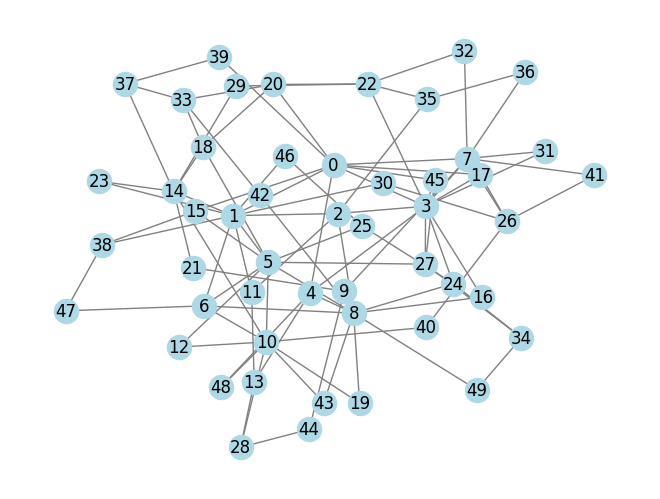

Number of nodes: 50
Number of edges: 98
Density: 0.08
Average degree: 3.92
Is connected: True
Average clustering coefficient: 0.14452958152958154
Diameter: 5
Average shortest path length: 2.7755102040816326


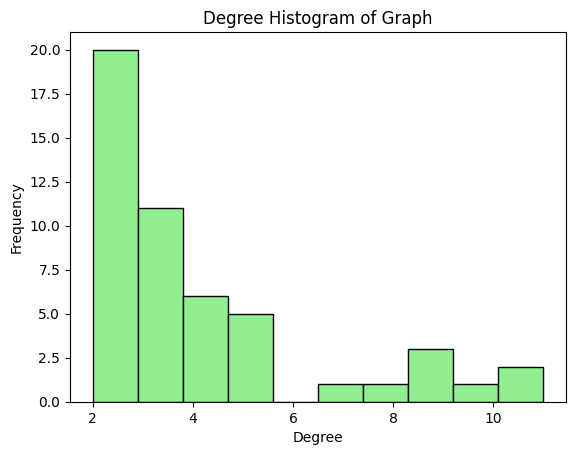

In [3]:
extended_barabasi = nx.extended_barabasi_albert_graph(50, 2, p=0.1, q=0.05, seed=42)
nx.draw_spring(
    extended_barabasi, with_labels=True, node_color="lightblue", edge_color="gray"
)
plt.show()
print_graph_properties(extended_barabasi)

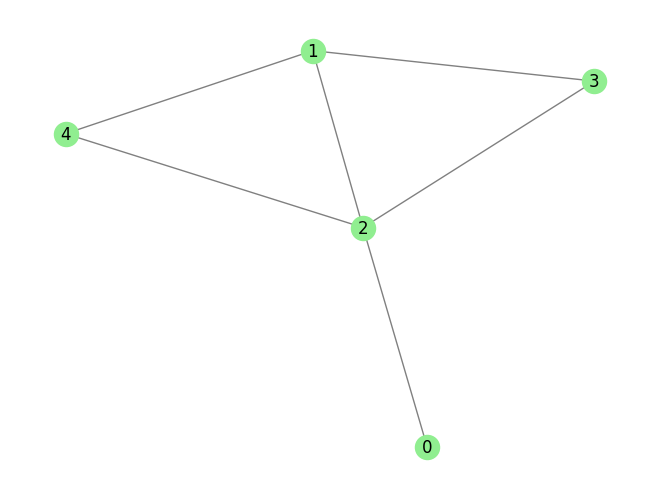

Number of nodes: 5
Number of edges: 6
Density: 0.6
Average degree: 2.4
Is connected: True
Average clustering coefficient: 0.6
Diameter: 2
Average shortest path length: 1.4


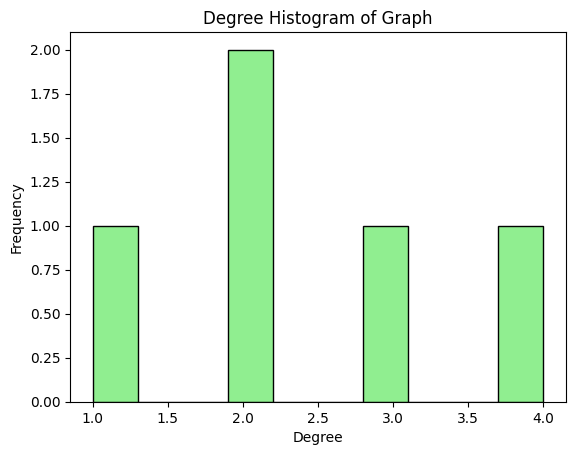

In [4]:
powerlaw = nx.powerlaw_cluster_graph(5, 2, 0.5, seed=42)
nx.draw_spring(powerlaw, with_labels=True, node_color="lightgreen", edge_color="gray")
plt.show()
print_graph_properties(powerlaw)


From the graphs, it looks like the extended barabasi provides more spread out graph, we will continue with this method.


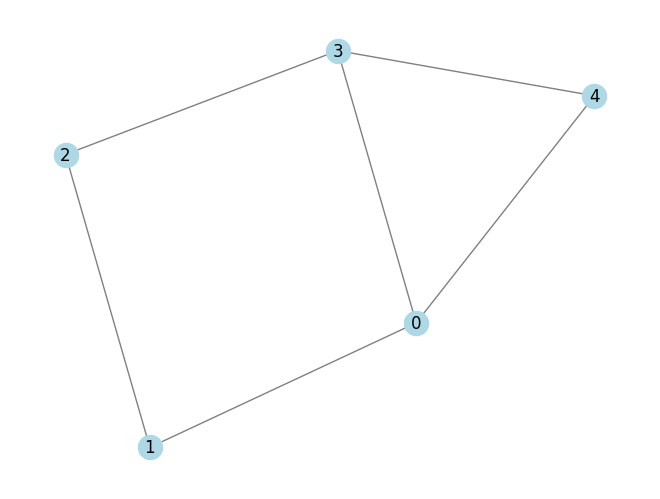

Number of nodes: 5
Number of edges: 6
Density: 0.6
Average degree: 2.4
Is connected: True
Average clustering coefficient: 0.3333333333333333
Diameter: 2
Average shortest path length: 1.4


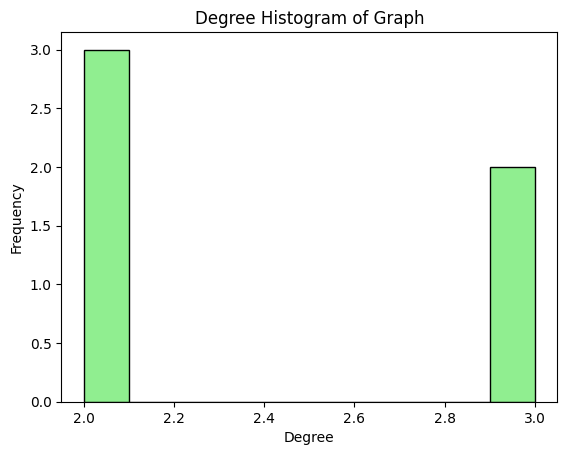

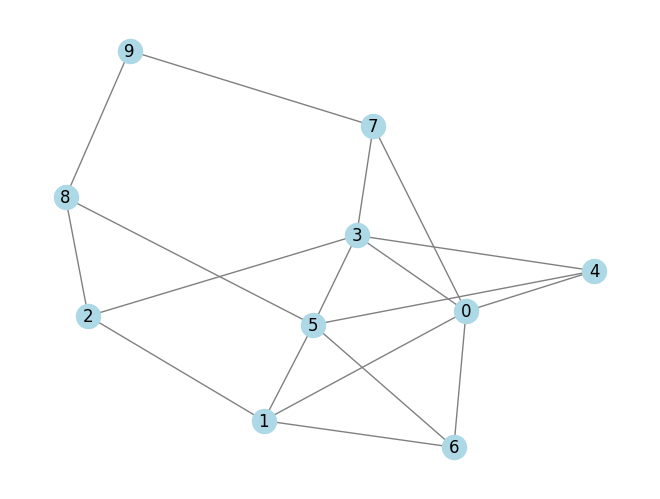

Number of nodes: 10
Number of edges: 18
Density: 0.4
Average degree: 3.6
Is connected: True
Average clustering coefficient: 0.27999999999999997
Diameter: 3
Average shortest path length: 1.6888888888888889


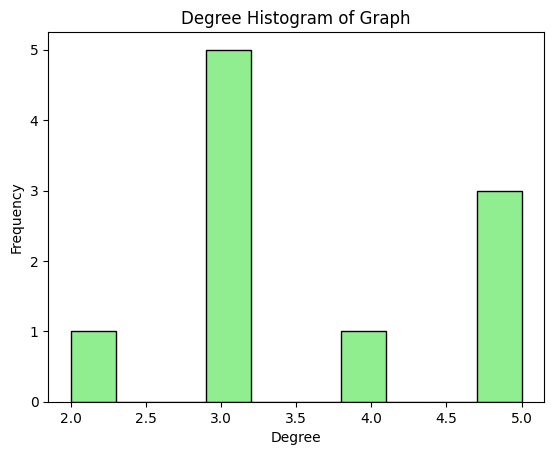

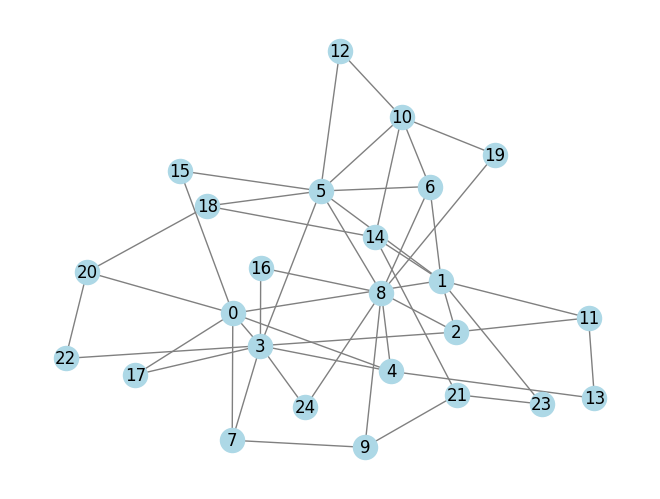

Number of nodes: 25
Number of edges: 48
Density: 0.16
Average degree: 3.84
Is connected: True
Average clustering coefficient: 0.168
Diameter: 4
Average shortest path length: 2.31


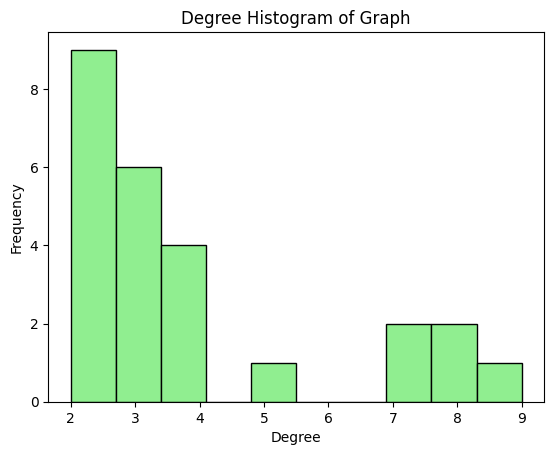

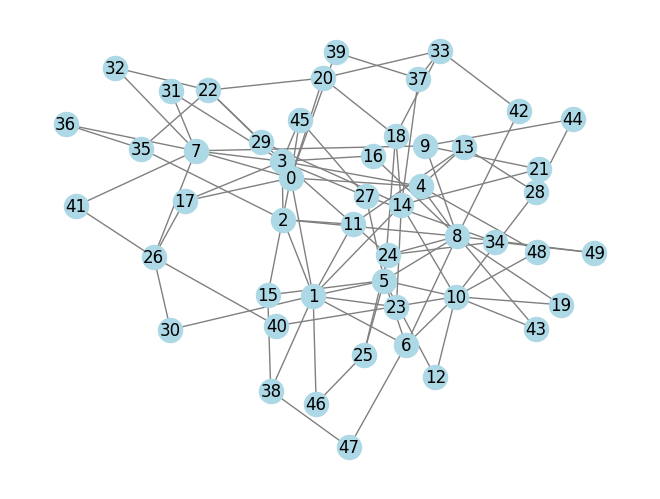

Number of nodes: 50
Number of edges: 98
Density: 0.08
Average degree: 3.92
Is connected: True
Average clustering coefficient: 0.14452958152958154
Diameter: 5
Average shortest path length: 2.7755102040816326


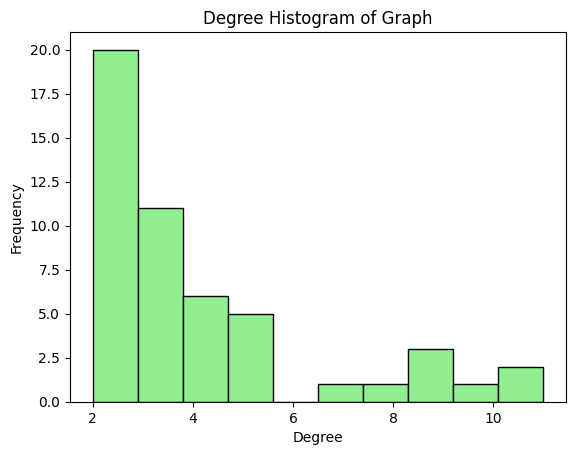

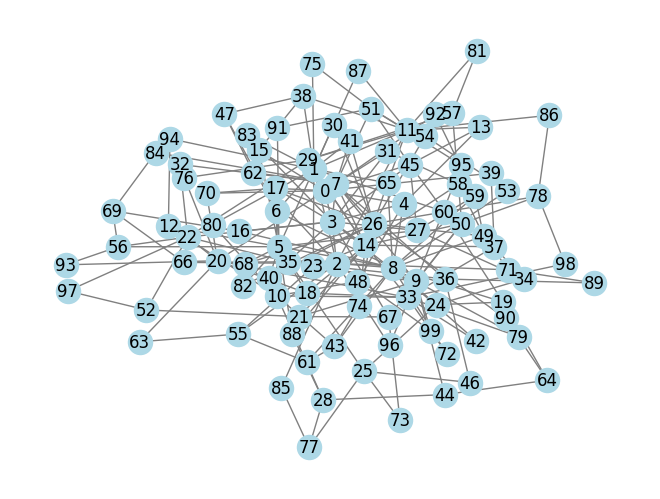

Number of nodes: 100
Number of edges: 222
Density: 0.044848484848484846
Average degree: 4.44
Is connected: True
Average clustering coefficient: 0.08935699104816752
Diameter: 6
Average shortest path length: 2.978989898989899


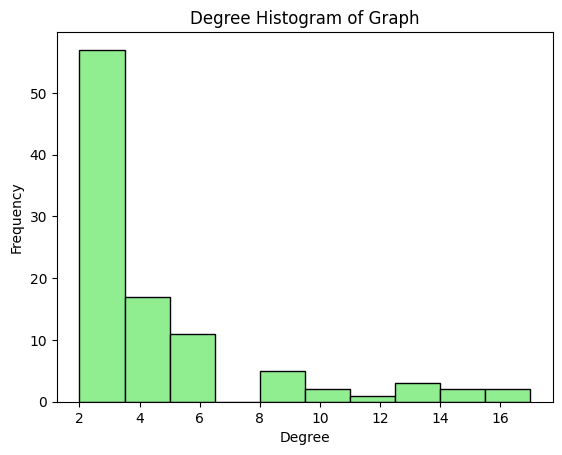

In [5]:
sizes = [5, 10, 25, 50, 100]
graphs = [
    nx.extended_barabasi_albert_graph(size, 2, p=0.1, q=0.05, seed=42) for size in sizes
]
for graph in graphs:
    nx.draw_spring(graph, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.show()
    print_graph_properties(graph)

In the next steps, we generate and save the datasets in different sizes. The sizes chosen for future experiments are 5, 10, 25, 50 and 100. This might be further extended to cover even bigger graphs.


Ako vieme vygenerovat dataset ? Podla mna je worthy vybrat nejaky hlavny uzol (asi podla nejakej centrality), vygenerovat jeho osobu a potom nahodne robit extension. Do kontextu vzdy posleme okolie daneho uzla (i guess ako ego network) a vsetky uz vygenerovane osoby. Rozsirujeme postupne, ako strom od toho jedneho vrcholu.

Potom vezmeme ten jeden vrchol a zmenime ho - infuse o nejaku informaciu, ktoru chceme zistit, ci (a ako rychlo) bude sirit.


In [6]:
for graph, size in zip(graphs, sizes):
    print(f"Generating dataset for graph of size {size}...")
    dataset = await generate_dataset_from_graph(
        graph, nx.betweenness_centrality(graph), client, model
    )
    with open(f"../data/synthetic_{size}.json", "w") as f:
        f.write(dataset.model_dump_json(indent=1))



Generating dataset for graph of size 5...
Generating dataset for graph of size 10...
Generating dataset for graph of size 25...
Generating dataset for graph of size 50...
Generating dataset for graph of size 100...
